In [1]:
# import some keras and basic module 

from __future__ import print_function 
import tensorflow.keras as keras
import tensorflow as tf
# data set cifar 10 
from tensorflow.keras.datasets import cifar10 

# basic preprocesssing for image data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# construct neural network 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten 

from tensorflow.keras.layers import Conv2D, MaxPooling2D

import os 

import numpy as np 

import matplotlib.pyplot as plt



In [2]:

## basic parameters 
batch_size = 32 
num_classes = 10 
num_epochs = 300 
is_data_augmentation = False 
num_predictions = 20 
model_dir = 'models'
model_filename = 'keras_cifar10_model_5_filtersize.h1'



In [3]:
#read data and split data into train and test set

(train_set,train_label),(test_set,test_label) = cifar10.load_data() 

print('the shape of training data set is: ',train_set.shape) 

# print number of train and test samples 

# train samples 50000
#print(train_set.shape[0] , 'train samples') 

# test samples 10000
#print(test_set.shape[0] , 'test samples') 

#print(train_label)

the shape of training data set is:  (50000, 32, 32, 3)


In [4]:
# Convert class label to binary vector 
train_label = keras.utils.to_categorical(train_label,num_classes)
test_label  = keras.utils.to_categorical(test_label,num_classes) 
print(train_label.shape)
print(test_label.shape)

(50000, 10)
(10000, 10)


the code input for Conv2D 
```
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```

In [5]:
# construct the model 

cnn_model = Sequential() 


# convolutional layer stride 1 no padding nfilters = 6 input_shape = 32*32*3
# acitvation = softmax
cnn_model.add(Conv2D(20,(5,5),padding='valid',input_shape=train_set.shape[1:], ))
cnn_model.add(Activation('relu'))

# max-pooling layer window size 2*2
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

# convolutional layer stride 1 no padding nfilters = 6 input_shape = 14*14*6
# activation = softmax
cnn_model.add(Conv2D(40,(5,5),padding ='valid'))
cnn_model.add(Activation('relu'))

# max-pooling layer window size 2*2
cnn_model.add(MaxPooling2D(pool_size =(2,2) ))

# flatten 2d to 1d 
cnn_model.add(Flatten())


# full connected layer nfilters = 120 

cnn_model.add(Dense(150,activation = 'relu' )) 

# full connected layer nfilters = 84 
cnn_model.add(Dense(90, activation = 'relu'))

# last full connected layer nfilters = 10 
cnn_model.add(Dense(10 , activation = 'softmax'))



In [6]:


# initialization of optimizer 
opt = keras.optimizers.RMSprop(learning_rate = 0.0001,decay = 1e-6)

# train the model by optimizer
cnn_model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

train_set = train_set.astype('float32')
test_set = test_set.astype('float32') 

train_set /= 255 
test_set /= 255 

if not is_data_augmentation:
    print('Not using data augmentation.')
    cnn_history = cnn_model.fit(train_set, train_label,
              batch_size=batch_size,
              epochs=num_epochs,
              validation_data=(test_set, test_label),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    augument_data_set = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        zca_epsilon=1e-06,                    # epsilon for ZCA whitening
        rotation_range=0,                     # randomly rotate images in the range (degrees, 0 to 180)
        
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
        
    # compute quantities required for feature-wise normalization 
    # (std, mean ,and pricipal components if ZCA whitening is applied)
    augument_data_set.fit(train_set) 
    
    
    # Fit the model on the batches generated by augument_data_set.flow() 
    
    cnn_model.fit_generator(augument_data_set.flow(train_set,train_label ,
                                                  batch_size=batch_size),
                           epochs = num_epochs, 
                           validation_data = (test_set,test_label),
                           workers = 4 )
    
# save model and weights 
if not os.path.isdir(model_dir): 
    os.makedirs(model_dir) 
model_path = os.path.join(model_dir,model_filename)
cnn_model.save(model_path)
print("CNN Model saved at %s " % model_path)

# Score trained model 

test_loss_value, test_metric_value = cnn_model.evaluate(test_set,test_label,verbose =1 )
train_loss_value, train_metric_value = cnn_model.evaluate(train_set,train_label,verbose =1)


print("Train loss: ", train_loss_value) 
print("Trian metric: ", train_metric_value)

print("Test loss: ", test_loss_value)
print("Test accuracy:", test_metric_value)
print(cnn_history.history)


Not using data augmentation.
Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1561/1563 [============================>.] - ETA: 0s - loss: 1.9262 - accuracy: 0.3082WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000222DE8ED8B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export A

1563/1563 [==============================] - 24s 15ms/step - loss: 0.4541 - accuracy: 0.8447 - val_loss: 1.1980 - val_accuracy: 0.6577
Epoch 99/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.4502 - accuracy: 0.8452 - val_loss: 1.2082 - val_accuracy: 0.6558
Epoch 100/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.4447 - accuracy: 0.8490 - val_loss: 1.2008 - val_accuracy: 0.6600
Epoch 101/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.4391 - accuracy: 0.8497 - val_loss: 1.2353 - val_accuracy: 0.6555
Epoch 102/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.4357 - accuracy: 0.8519 - val_loss: 1.2426 - val_accuracy: 0.6532
Epoch 103/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.4314 - accuracy: 0.8526 - val_loss: 1.2080 - val_accuracy: 0.6636
Epoch 104/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.4268 - accuracy: 0.8537 - val_loss: 1.

1563/1563 [==============================] - 23s 15ms/step - loss: 0.2384 - accuracy: 0.9218 - val_loss: 1.7787 - val_accuracy: 0.6492
Epoch 154/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.2340 - accuracy: 0.9233 - val_loss: 1.7988 - val_accuracy: 0.6419
Epoch 155/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.2303 - accuracy: 0.9249 - val_loss: 1.8002 - val_accuracy: 0.6508
Epoch 156/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.2274 - accuracy: 0.9257 - val_loss: 1.8439 - val_accuracy: 0.6440
Epoch 157/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.2249 - accuracy: 0.9262 - val_loss: 1.8089 - val_accuracy: 0.6454
Epoch 158/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.2208 - accuracy: 0.9282 - val_loss: 1.8812 - val_accuracy: 0.6473
Epoch 159/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.2181 - accuracy: 0.9292 - val_loss: 1

1563/1563 [==============================] - 24s 15ms/step - loss: 0.0982 - accuracy: 0.9711 - val_loss: 2.7638 - val_accuracy: 0.6418
Epoch 209/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0964 - accuracy: 0.9717 - val_loss: 2.8086 - val_accuracy: 0.6375
Epoch 210/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0933 - accuracy: 0.9729 - val_loss: 2.7565 - val_accuracy: 0.6376
Epoch 211/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0935 - accuracy: 0.9721 - val_loss: 2.8047 - val_accuracy: 0.6357
Epoch 212/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0903 - accuracy: 0.9735 - val_loss: 2.8324 - val_accuracy: 0.6415
Epoch 213/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0900 - accuracy: 0.9735 - val_loss: 2.8617 - val_accuracy: 0.6382
Epoch 214/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0870 - accuracy: 0.9751 - val_loss: 2

1563/1563 [==============================] - 23s 15ms/step - loss: 0.0343 - accuracy: 0.9911 - val_loss: 4.0218 - val_accuracy: 0.6323
Epoch 264/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0332 - accuracy: 0.9914 - val_loss: 4.1144 - val_accuracy: 0.6343
Epoch 265/300
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0335 - accuracy: 0.9918 - val_loss: 4.1111 - val_accuracy: 0.6356
Epoch 266/300
1563/1563 [==============================] - 23s 14ms/step - loss: 0.0323 - accuracy: 0.9916 - val_loss: 4.1137 - val_accuracy: 0.6351
Epoch 267/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0312 - accuracy: 0.9927 - val_loss: 4.1963 - val_accuracy: 0.6331
Epoch 268/300
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0319 - accuracy: 0.9921 - val_loss: 4.1499 - val_accuracy: 0.6378
Epoch 269/300
1563/1563 [==============================] - 23s 14ms/step - loss: 0.0309 - accuracy: 0.9922 - val_loss: 4

Text(0.5, 1.0, 'test loss and test accuracy')

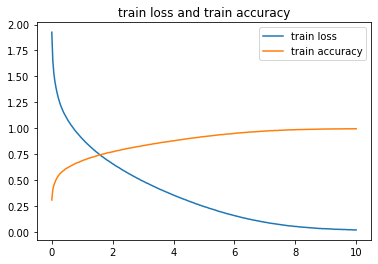

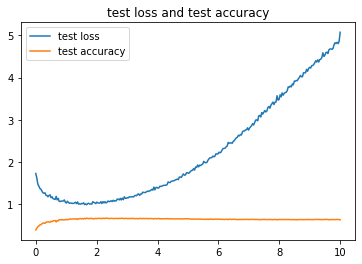

In [7]:

# get history data
epoth_x = np.linspace(0, 10, num_epochs, endpoint=True)
train_loss = cnn_history.history['loss']
train_accuracy = cnn_history.history['accuracy']
test_loss = cnn_history.history['val_loss']
test_accuracy = cnn_history.history['val_accuracy']

# plot train loss and accuracy
plt.figure() 
plt.plot(epoth_x, train_loss,label = 'train loss')
plt.plot(epoth_x,train_accuracy,label = 'train accuracy')
plt.title("train loss and train accuracy")
plt.legend()


# plot test loss and accuracy
plt.figure() 
plt.plot(epoth_x, test_loss, label = 'test loss')
plt.plot(epoth_x,test_accuracy, label = 'test accuracy')
plt.legend()
plt.title("test loss and test accuracy")

# get max test accuracy and 

print("The max test accuracy is ",max(test_accuracy))

